# Different implementations of a Marine Data Science application

As an example application, we will use the calculation of a time series of horizontally averaged kinetic-energy $e$
\begin{eqnarray}
    e(t, y, x) & = & \frac{1}{2}\frac{\int{\rm d}y{\rm d}x\,u(t, y, x)^2 + \int{\rm d}y{\rm d}x\,v(t, y, x)^2}{\int{\rm d}y{\rm d}x} \\
    u(t, y, x) & = & -\frac{G}{F} \frac{\partial ssh(t, y, x)}{\partial y} \\
    v(t, y, x) & = & \frac{G}{F} \frac{\partial ssh(t, y, x)}{\partial x}
\end{eqnarray}
where $t$ indicates time, where $y$ and $x$ are spatial coordinates, and where horizontal surface-velocities $u$ and $v$ are caculatd from sea-level $ssh$ using the Geostrophic balance.

The coordinate system is chosen to have a cyclic boundary condition in, both, $y$ and $x$ and there are the physical constants $G$ and the Coriolis parameter $F$.

## Tech preamble and parameters

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# parameters
rng_seed = 12345

Nt = 30  # number of time steps
Ny = 20  # number of grid points in y direction
Nx = 10  # number of grid points in x direction

dy = 200e3  # grid constant in y (in meters)
dx = 400e3  # grid constant in x (in meters)

G0 = 9.81  # graviational acceleration (in meters / second^2)

F0 = 2 * 7.2921e-5 * 0.5  # Coriolis parameter (in 1/second) at 30 N

## Preparation of the input data

In [3]:
t = np.arange(Nt)  # time vector
y = np.arange(Ny) * dy  # positions in y
x = np.arange(Nx) * dx  # positions in x

# chose a random sea level field
np.random.seed(rng_seed)
ssh = 3 * np.random.normal(size=(Nt, Ny, Nx))

## Implemetation 1

This is the correct implementation that respects the cyclic boundary condition in both x and y.

In [4]:
def energy_average_1(ssh=None, t=None, y=None, x=None, G=G0, F=F0):
    
    # get grid constant
    dy = y[1] - y[0]
    dx = x[1] - x[0]
    
    # calculate u and v using geostrophy
    u = - G / F * np.diff(ssh[:, np.arange(-1, y.size), :], axis=1) / dy
    v = G / F * np.diff(ssh[:, :, np.arange(-1, x.size)], axis=2) / dx
    
    # calculate energy
    e = 0.5 * (u ** 2 + v ** 2)
    
    # average energy in x and y
    e_ave = e.mean(axis=-1).mean(axis=-1)
    
    return e_ave

## Implemetation 2

This implementation does not respect the cyclic point.

In [5]:
def energy_average_2(ssh=None, t=None, y=None, x=None, G=G0, F=F0):

    # get grid constant
    dy = y[1] - y[0]
    dx = x[1] - x[0]
    
    # calculate u and v using geostrophy
    u = -G / F * np.diff(ssh[:, :, :-1], axis=1) / dy
    v = G / F * np.diff(ssh[:, :-1, :], axis=2) / dx
    
    # calculate energy
    e = 0.5 * (u ** 2 + v ** 2)
    
    # average energy in x and y
    e_ave = e.mean(axis=-1).mean(axis=-1)
    
    return e_ave

## Compare implementations

A regression test would easily detect that there is a difference in the implementations:

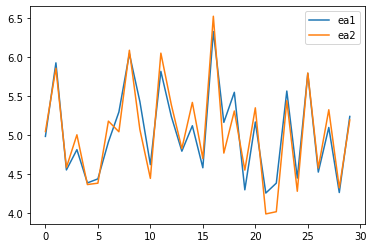

In [6]:
plt.plot(t, energy_average_1(ssh, t, y, x, G=G0, F=F0), label="ea1");
plt.plot(t, energy_average_2(ssh, t, y, x, G=G0, F=F0), label="ea2");
plt.gca().legend();

In [7]:
print(np.allclose(
    energy_average_1(ssh, t, y, x, G=G0, F=F0),
    energy_average_2(ssh, t, y, x, G=G0, F=F0)
))

False


## Check metamorphic relations for implementation 1

We can easily find symmetries of the equations above.  Below is a demonstration that for a transformaion of the input data along these symmetries, the first holds.

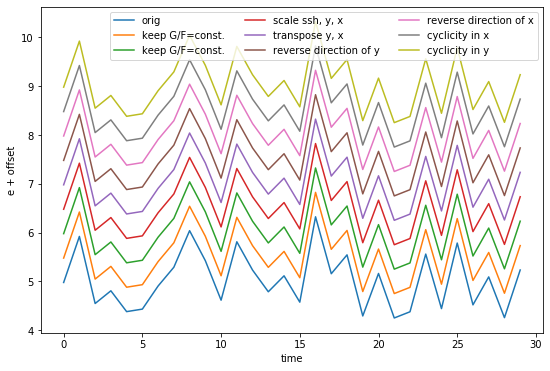

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6)) 

eave = energy_average_1

ax.plot(t, eave(ssh, t, y, x, G=G0, F=F0), label="orig")
ax.plot(t, eave(ssh, t, y, x, G=G0 * 5, F=F0 * 5) + 0.5, label="keep G/F=const.")
ax.plot(t, eave(ssh, t, y, x, G=1, F=F0/G0) + 1.0, label="keep G/F=const.")
ax.plot(t, eave(7 * ssh, t, 7 * y, 7 * x) + 1.5, label="scale ssh, y, x")
ax.plot(t, eave(ssh.transpose([0, 2, 1]), t, y=x, x=y) + 2.0, label="transpose y, x")
ax.plot(t, eave(ssh[:, ::-1, :], t, y=y[::-1], x=x) + 2.5, label="reverse direction of y")
ax.plot(t, eave(ssh[:, ::-1], t, y=y, x=x[::-1]) + 3.0, label="reverse direction of x")
ax.plot(t, eave(np.roll(ssh, 7, axis=-1), t, y, x=np.roll(x, 7)) + 3.5, label="cyclicity in x")
ax.plot(t, eave(np.roll(ssh, 7, axis=-2), t, y=np.roll(y, 7), x=x) + 4.0, label="cyclicity in y")

ax.set_xlabel("time")
ax.set_ylabel("e + offset")

ax.legend(ncol=3);

## Check metamorphic relations for implementation 2

Applying the same transformations to input data of the second implementation reveals that the cyclic boundary condidtion is not respected.

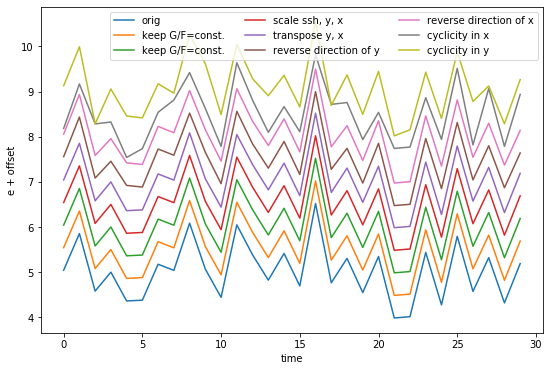

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6)) 

eave = energy_average_2

ax.plot(t, eave(ssh, t, y, x, G=G0, F=F0), label="orig")
ax.plot(t, eave(ssh, t, y, x, G=G0 * 5, F=F0 * 5) + 0.5, label="keep G/F=const.")
ax.plot(t, eave(ssh, t, y, x, G=1, F=F0/G0) + 1.0, label="keep G/F=const.")
ax.plot(t, eave(7 * ssh, t, 7 * y, 7 * x) + 1.5, label="scale ssh, y, x")
ax.plot(t, eave(ssh.transpose([0, 2, 1]), t, y=x, x=y) + 2.0, label="transpose y, x")
ax.plot(t, eave(ssh[:, ::-1, :], t, y=y[::-1], x=x) + 2.5, label="reverse direction of y")
ax.plot(t, eave(ssh[:, ::-1], t, y=y, x=x[::-1]) + 3.0, label="reverse direction of x")
ax.plot(t, eave(np.roll(ssh, 7, axis=-1), t, y, x=np.roll(x, 7)) + 3.5, label="cyclicity in x")
ax.plot(t, eave(np.roll(ssh, 7, axis=-2), t, y=np.roll(y, 7), x=x) + 4.0, label="cyclicity in y")

ax.set_xlabel("time")
ax.set_ylabel("e + offset")

ax.legend(ncol=3);